In [1]:
import os
import numpy as np
import cv2
from glob import glob
import tensorflow as tf
from sklearn.model_selection import train_test_split

def load_data(path, split=0.1):
    images = sorted(glob(os.path.join(path, "images/*")))
    masks = sorted(glob(os.path.join(path, "masks/*")))

    total_size = len(images)
    valid_size = int(split * total_size)
    test_size = int(split * total_size)

    train_x, valid_x = train_test_split(images, test_size=valid_size, random_state=42)
    train_y, valid_y = train_test_split(masks, test_size=valid_size, random_state=42)

    train_x, test_x = train_test_split(train_x, test_size=test_size, random_state=42)
    train_y, test_y = train_test_split(train_y, test_size=test_size, random_state=42)

    return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)

def read_image(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (256, 256))
    x = x/255.0
    return x

def read_mask(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (256, 256))
    x = x/255.0
    x = np.expand_dims(x, axis=-1)
    return x

def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float64, tf.float64])
    x.set_shape([256, 256, 3])
    y.set_shape([256, 256, 1])
    return x, y

def tf_dataset(x, y, batch=8):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch)
    dataset = dataset.repeat()
    return dataset

#a = read_image('/kaggle/input/kvasir-seg/Kvasir-SEG/images/cju0qkwl35piu0993l0dewei2.jpg')
#a =  ['/kaggle/input/kvasir-seg/Kvasir-SEG/images/cju7do8c72dbo0801vxfzxdc4.jpg', '/kaggle/input/kvasir-seg/Kvasir-SEG/images/cju8cgi2kspp308011nxdtjp6.jpg', '/kaggle/input/kvasir-seg/Kvasir-SEG/images/cju7dxffn2eam0817qxosfwch.jpg', '/kaggle/input/kvasir-seg/Kvasir-SEG/images/cju88rl5eo94l0850kf5wtrm1.jpg']
#dataset = tf.data.Dataset.from_tensor_slices(a)
#for item in dataset:
 #   print(item.numpy().decode('utf-8')) 

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

def conv_block(x, num_filters):
    x = Conv2D(num_filters, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def build_model():
    size = 256
    #num_filters = [32, 64, 128, 256 , 512]
    num_filters = [64,128, 256, 512 , 1024]
    inputs = Input((size, size, 3))

    skip_x = []
    x = inputs
    ## Encoder
    for f in num_filters:
        x = conv_block(x, f)
        skip_x.append(x)
        x = MaxPool2D((2, 2))(x)

    ## Bridge
    x = conv_block(x, num_filters[-1])

    num_filters.reverse()
    skip_x.reverse()
    ## Decoder
    for i, f in enumerate(num_filters):
        x = UpSampling2D((2, 2))(x)
        xs = skip_x[i]
        x = Concatenate()([x, xs])
        x = conv_block(x, f)

    ## Output
    x = Conv2D(1, (1, 1), padding="same")(x)
    x = Activation("sigmoid")(x)

    return Model(inputs, x)


if __name__ == "__main__":
    model = build_model()
    model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                             

In [3]:

import os
import numpy as np
import cv2
from glob import glob
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

def iou(y_true, y_pred):
    def f(y_true, y_pred):
        intersection = (y_true * y_pred).sum()
        union = y_true.sum() + y_pred.sum() - intersection
        x = (intersection + 1e-15) / (union + 1e-15)
        x = x.astype(np.float32)
        return x
    return tf.numpy_function(f, [y_true, y_pred], tf.float32)

if __name__ == "__main__":
    ## Dataset
    path = "/kaggle/input/kvasir-seg/Kvasir-SEG"
    (train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_data(path)
    ## Hyperparameters
    batch = 8
    lr = 1e-4
    epochs = 100

    train_dataset = tf_dataset(train_x, train_y, batch=batch)
    valid_dataset = tf_dataset(valid_x, valid_y, batch=batch)

    model = build_model()

    opt = tf.keras.optimizers.Adam(lr)
    metrics = ["acc", tf.keras.metrics.Recall(), tf.keras.metrics.Precision(), iou]
    model.compile(loss="binary_crossentropy", optimizer=opt, metrics=metrics)

    callbacks = [
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4),
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=False),
        ModelCheckpoint("model.h5", save_best_only=True)
    ]

    train_steps = len(train_x)//batch
    valid_steps = len(valid_x)//batch

    if len(train_x) % batch != 0:
        train_steps += 1
    if len(valid_x) % batch != 0:
        valid_steps += 1
    model.fit(train_dataset,
        validation_data=valid_dataset,
        epochs=epochs,
        steps_per_epoch=train_steps,
        validation_steps=valid_steps,
        callbacks=callbacks)

Epoch 1/100
100/100 [==============================] - 66s 361ms/step - loss: 0.4017 - acc: 0.8311 - recall: 0.4570 - precision: 0.4729 - iou: 0.2028 - val_loss: 0.4736 - val_acc: 0.8306 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_iou: 0.1321 - lr: 1.0000e-04
Epoch 2/100
100/100 [==============================] - 30s 305ms/step - loss: 0.3006 - acc: 0.8744 - recall: 0.4750 - precision: 0.6533 - iou: 0.2594 - val_loss: 0.4942 - val_acc: 0.8306 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_iou: 0.0506 - lr: 1.0000e-04
Epoch 3/100
100/100 [==============================] - 30s 305ms/step - loss: 0.2654 - acc: 0.8891 - recall: 0.5323 - precision: 0.7138 - iou: 0.3103 - val_loss: 0.5243 - val_acc: 0.8304 - val_recall: 0.0021 - val_precision: 0.3868 - val_iou: 0.0423 - lr: 1.0000e-04
Epoch 4/100
100/100 [==============================] - 31s 306ms/step - loss: 0.2414 - acc: 0.8996 - recall: 0.5695 - precision: 0.7572 - iou: 0.3485 - val_loss: 0.4842 - val_acc: 0.8

In [8]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
def read_image(path):
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (256, 256))
    x = x/255.0
    return x

def read_mask(path):
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (256, 256))
    x = x/255.0
    x = np.expand_dims(x, axis=-1)
    return x

test_images = [read_image(path) for path in test_x]
test_images = np.array(test_images)

prediction_test = model.predict(test_images, batch_size=8)

true_labels = [read_mask(path) for path in test_y]
true_labels = np.array(true_labels)

binary_predictions = (prediction_test > 0.5).astype(int)
y_test_bool = (true_labels > 0.5).astype(bool)
accuracy_test = accuracy_score(np.ndarray.flatten(y_test_bool), np.ndarray.flatten(binary_predictions))
presision_score_test = precision_score(np.ndarray.flatten(y_test_bool), np.ndarray.flatten(binary_predictions))
recall_score_test = recall_score(np.ndarray.flatten(y_test_bool), np.ndarray.flatten(binary_predictions))


print(f'Độ chính xác: {accuracy_test * 100:.2f}%')
print(f'Precision:  {presision_score_test * 100:.2f}%')
print(f'Recall : {recall_score_test * 100:.2f}%')

13/13 [==============================] - 1s 95ms/step
Độ chính xác: 93.83%
Precision:  88.95%
Recall : 71.36%


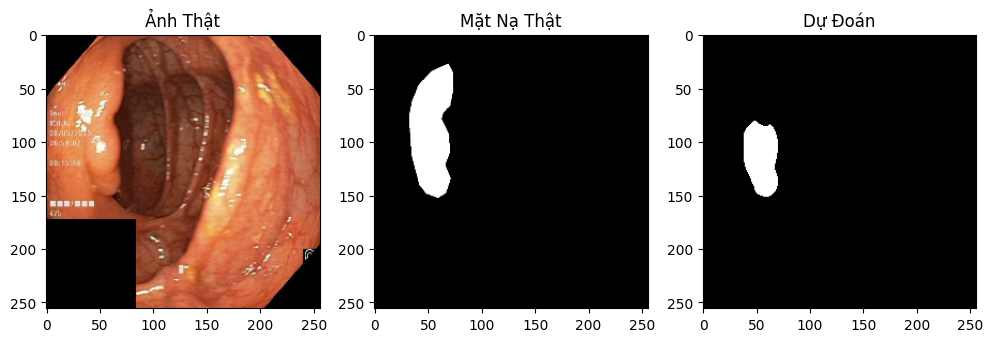

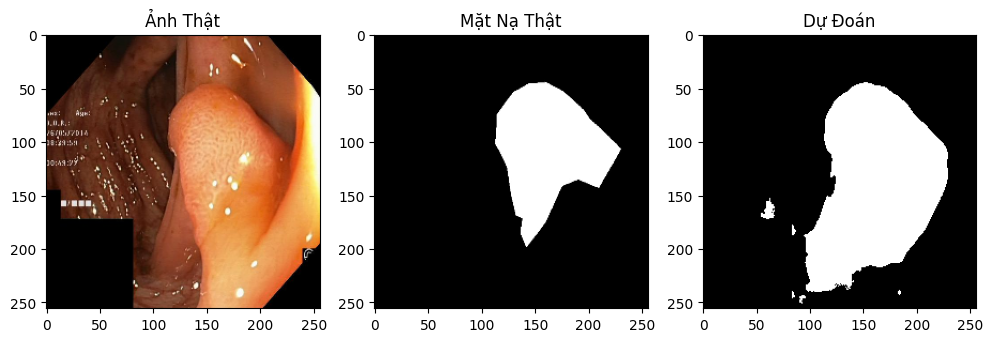

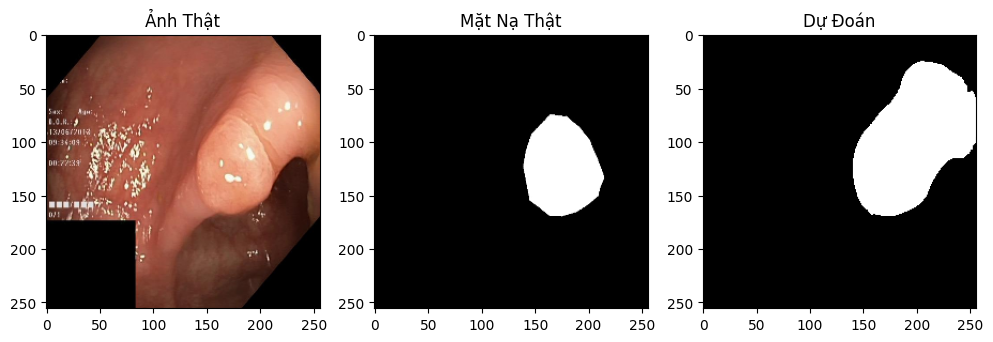

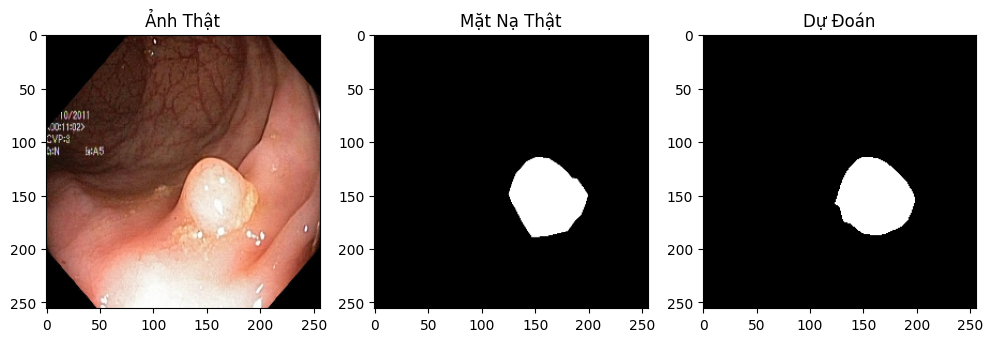

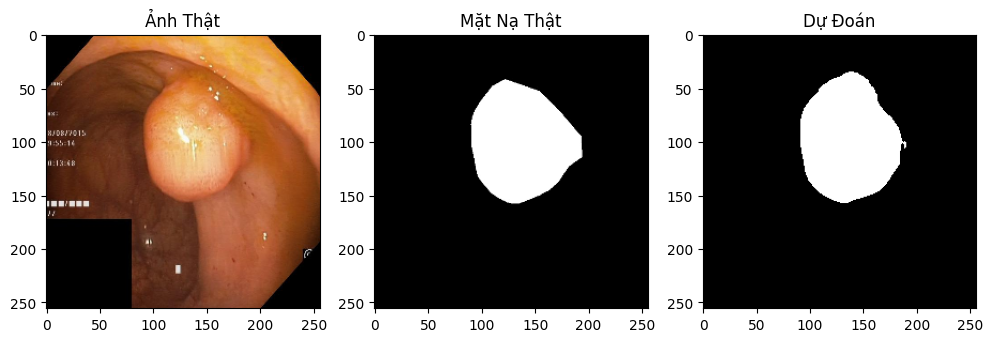

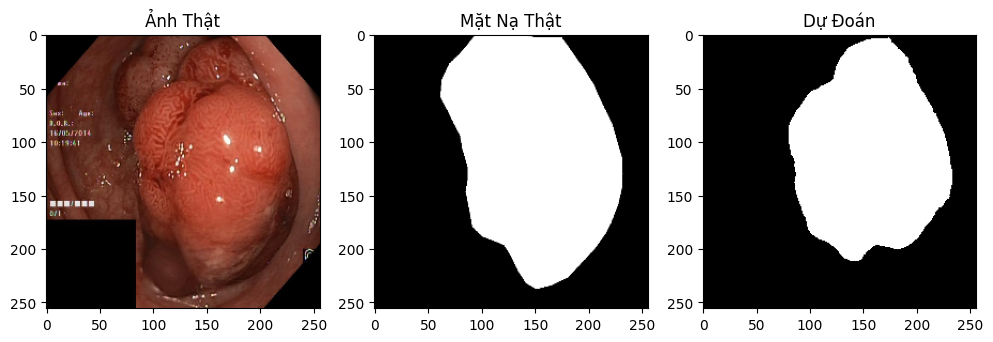

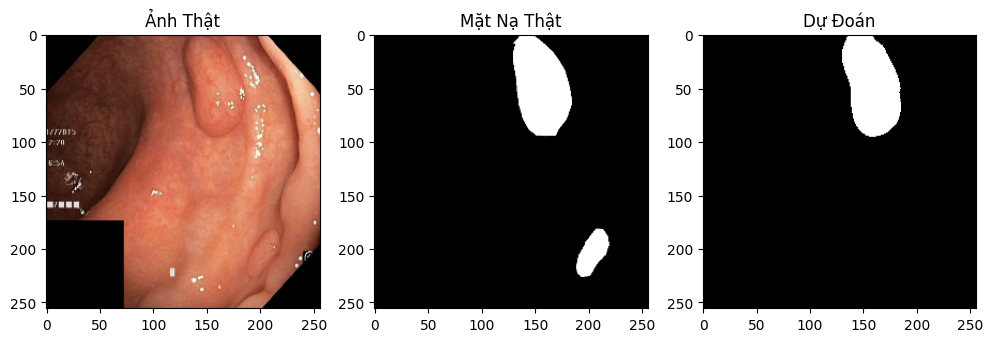

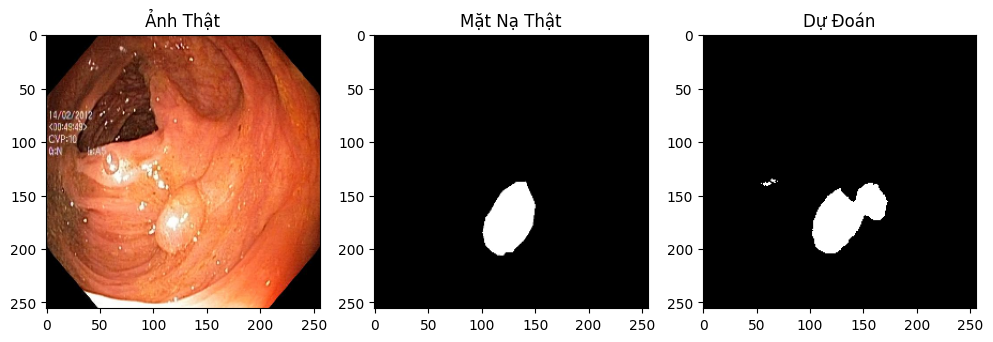

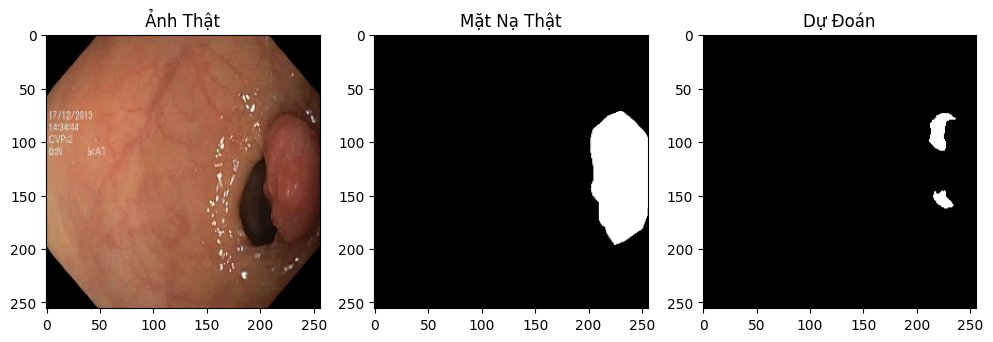

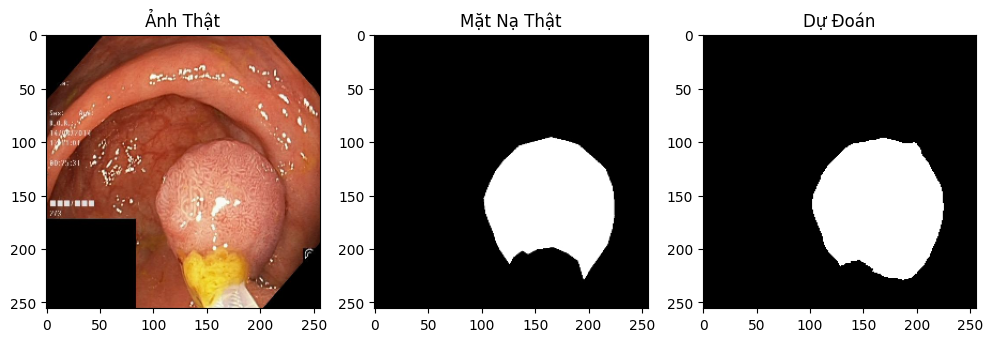

In [43]:
import matplotlib.pyplot as plt

first_10_images = test_images[:10]
first_10_true_labels = true_labels[:10]
first_10_predictions = binary_predictions[:10]

for i in range(10):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(first_10_images[i][...,::-1])
    plt.title('Ảnh Thật')
    
    plt.subplot(1, 3, 2)
    plt.imshow(first_10_true_labels[i], cmap='gray')
    plt.title('Mặt Nạ Thật')

    plt.subplot(1, 3, 3)
    plt.imshow(first_10_predictions[i], cmap='gray')
    plt.title('Dự Đoán')

    plt.show()